<a href="https://colab.research.google.com/github/SpicyTaco17/Solar-Energy-Forecasting/blob/main/Solar_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
!pip3 install xgboost
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex_filtered.csv to time_series_60min_singleindex_filtered.csv
Saving timestamp_utc.csv to timestamp_utc.csv
Saving weather_data_filtered.csv to weather_data_filtered.csv


In [3]:
import io
df_1 = pd.read_csv(io.BytesIO(uploaded['time_series_60min_singleindex_filtered.csv']))
df_2 = pd.read_csv(io.BytesIO(uploaded['weather_data_filtered.csv']))
df_3 = pd.read_csv(io.BytesIO(uploaded['timestamp_utc.csv']))
# Dataset is now stored in a Pandas Dataframe

In [4]:
df_2.iloc[:,-3:]

,FR_temperature,FR_radiation_direct_horizontal,FR_radiation_diffuse_horizontal
0,-1.670,0.0,0.0
1,-1.768,0.0,0.0
2,-1.841,0.0,0.0
3,-1.908,0.0,0.0
4,-1.962,0.0,0.0
...,...,...,...
43819,2.048,0.0,0.0
43820,1.995,0.0,0.0
43821,2.107,0.0,0.0
43822,2.280,0.0,0.0


In [5]:
df_total = df_3.join(df_2.iloc[:,-3:]).join(df_1.iloc[:,-3:]).iloc[:,1:]

In [6]:
df_total

,timestamp,FR_temperature,FR_radiation_direct_horizontal,FR_radiation_diffuse_horizontal,FR_load_actual_entsoe_transparency,FR_load_forecast_entsoe_transparency,FR_solar_generation_actual
0,23,-1.670,0.0,0.0,NaN,NaN,NaN
1,24,-1.768,0.0,0.0,NaN,NaN,NaN
2,1,-1.841,0.0,0.0,69773.0,69750.0,NaN
3,2,-1.908,0.0,0.0,66417.0,66300.0,NaN
4,3,-1.962,0.0,0.0,64182.0,63250.0,NaN
...,...,...,...,...,...,...,...
43819,18,2.048,0.0,0.0,68156.0,70300.0,0.0
43820,19,1.995,0.0,0.0,64771.0,66950.0,0.0
43821,20,2.107,0.0,0.0,62259.0,64150.0,0.0
43822,21,2.280,0.0,0.0,63774.0,64100.0,0.0


In [11]:
df_total = df_total.dropna(how='any',axis=0) #remove NA/null values since you have some

# ! pip install huggingface_hub
# from huggingface_hub import notebook_login
# notebook_login()

ground_truth = df_total['FR_solar_generation_actual'].copy() # seperate out ground truth (true amount of megawatts produced), put into seperate dataframe
parameter_dataset = df_total.drop('FR_solar_generation_actual', axis=1) # delete ground truth from main dataset, just left with parameters
(xTrain, xTest, yTrain, yTest) = train_test_split(parameter_dataset, ground_truth, test_size = .4, random_state=17) #do a train test split with 40% test and 60% train

xgbmodel = xgb.XGBRegressor() #xgboost - very cool
xgbmodel.fit(xTrain, yTrain) #fit the model to train data - training model
predictions = xgbmodel.predict(xTest) # make predictions from trained model

# Save model using sklearn
xgbmodel.save_model("model.json")

# Data Analysis

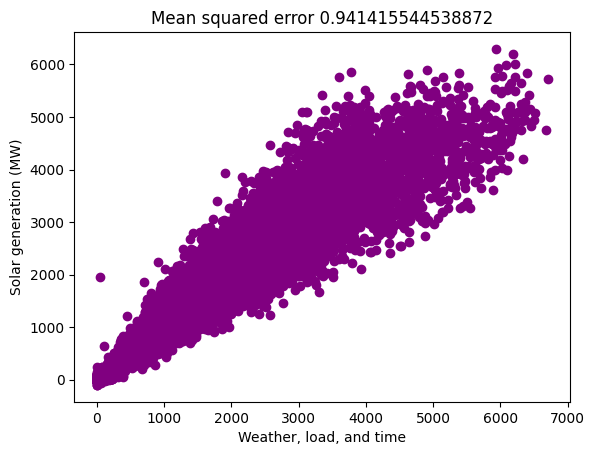

In [8]:
# generate graph
csfont = {'fontname':'Arial'}
plt.scatter(yTest, predictions, color = 'purple') #basically, the closer the graph is to a straight line (y=x), the more accurate the model is
plt.xlabel('Weather, load, and time', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)
err = r2_score(yTest, predictions) #utilize r2 score, value in title of graph
plt.title('Mean squared error ' + str(err))
plt.show()

Text(0, 0.5, 'Solar generation (MW)')

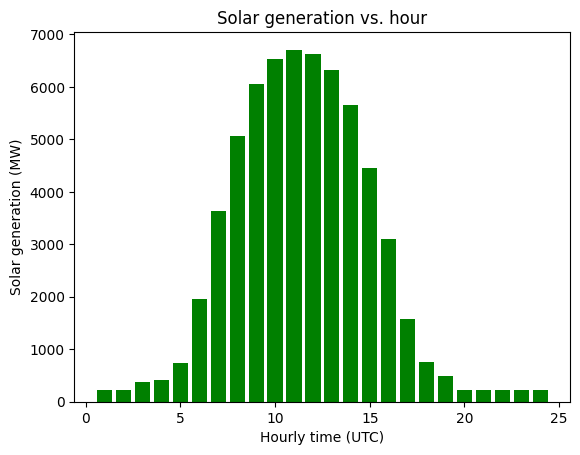

In [ ]:
# create plot
plt.bar(df_total['timestamp'], df_total['FR_solar_generation_actual'], color = 'green')
plt.title('Solar generation vs. hour')
plt.xlabel('Hourly time (UTC)', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)

Text(0, 0.5, 'Solar generation (MW)')

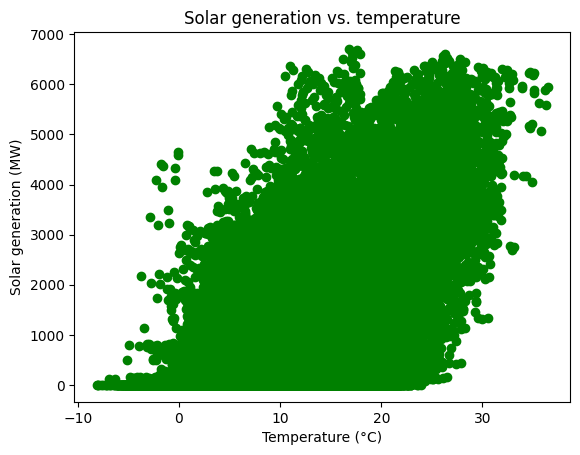

In [ ]:
plt.scatter(df_total['FR_temperature'], df_total['FR_solar_generation_actual'], color = 'green')
plt.title('Solar generation vs. temperature')
plt.xlabel('Temperature (°C)', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)

Text(0, 0.5, 'Solar generation (MW)')

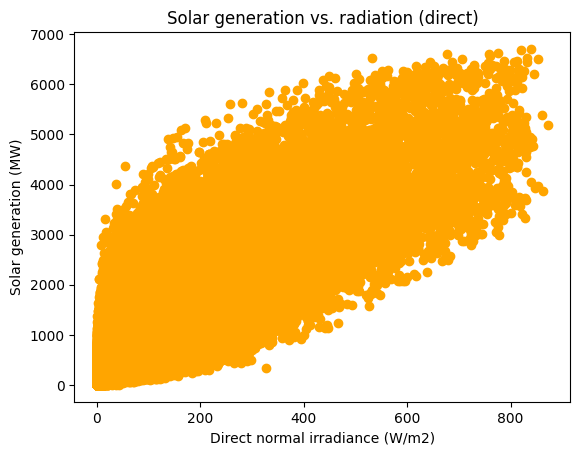

In [ ]:
plt.scatter(df_total['FR_radiation_direct_horizontal'], df_total['FR_solar_generation_actual'], color = 'orange')
plt.title('Solar generation vs. radiation (direct)')
plt.xlabel('Direct normal irradiance (W/m2)', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)

Text(0, 0.5, 'Solar generation (MW)')

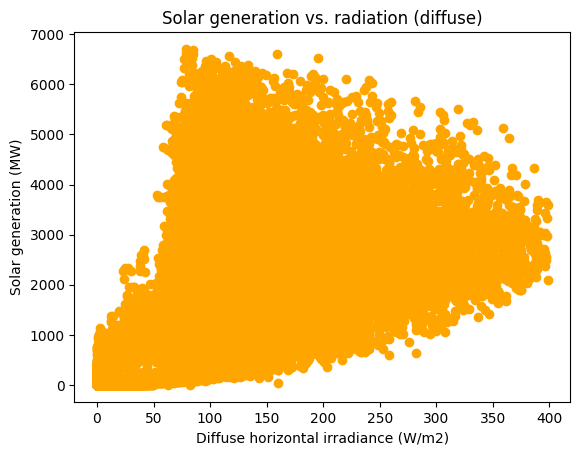

In [ ]:
plt.scatter(df_total['FR_radiation_diffuse_horizontal'], df_total['FR_solar_generation_actual'], color = 'orange')
plt.title('Solar generation vs. radiation (diffuse)')
plt.xlabel('Diffuse horizontal irradiance (W/m2)', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)

In [ ]:
df_global_radiation = df_total['FR_radiation_diffuse_horizontal'] + df_total['FR_radiation_direct_horizontal']
df_global_radiation

9        188.9109
10       267.6331
11       298.8877
12       281.2634
13       218.0092
           ...   
43819      0.0000
43820      0.0000
43821      0.0000
43822      0.0000
43823      0.0000
Length: 43786, dtype: float64

Text(0, 0.5, 'Solar generation (MW)')

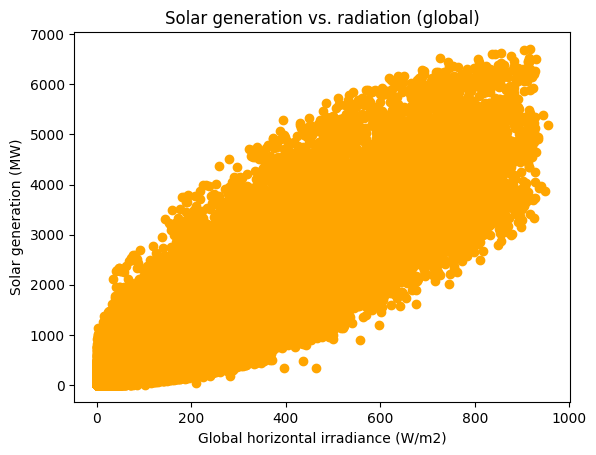

In [ ]:
plt.scatter(df_global_radiation, df_total['FR_solar_generation_actual'], color = 'orange')
plt.title('Solar generation vs. radiation (global)')
plt.xlabel('Global horizontal irradiance (W/m2)', **csfont)
plt.ylabel('Solar generation (MW)', **csfont)

Text(0, 0.5, 'Direct normal irradiance (W/m2)')

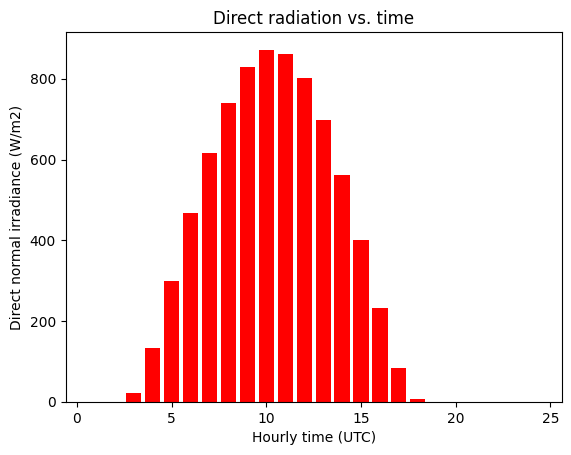

In [ ]:
plt.bar(df_total['timestamp'], df_total['FR_radiation_direct_horizontal'], color = 'red')
plt.title('Direct radiation vs. time')
plt.xlabel('Hourly time (UTC)', **csfont)
plt.ylabel('Direct normal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Diffuse horizontal irradiance (W/m2)')

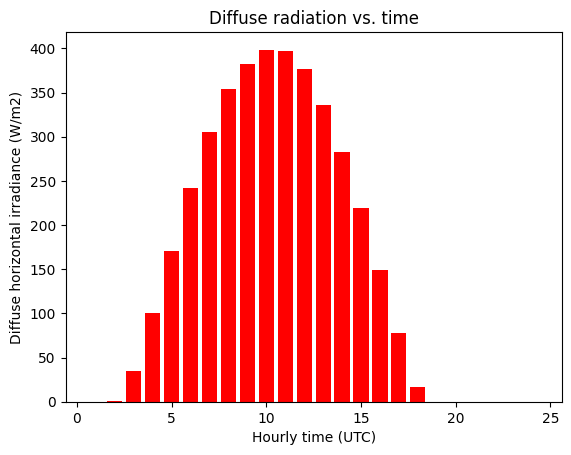

In [ ]:
plt.bar(df_total['timestamp'], df_total['FR_radiation_diffuse_horizontal'], color = 'red')
plt.title('Diffuse radiation vs. time')
plt.xlabel('Hourly time (UTC)', **csfont)
plt.ylabel('Diffuse horizontal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Global horizontal irradiance (W/m2)')

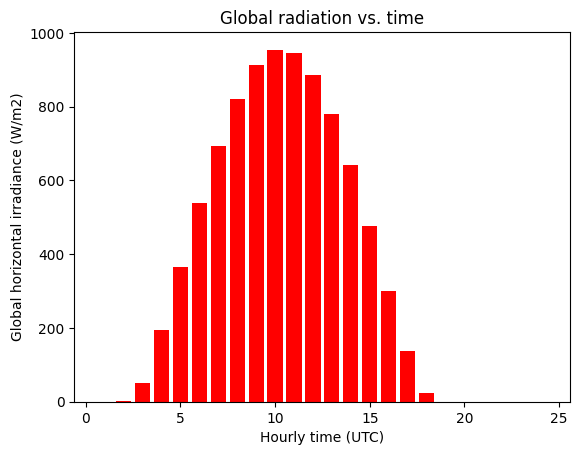

In [ ]:
plt.bar(df_total['timestamp'], df_global_radiation, color = 'red')
plt.title('Global radiation vs. time')
plt.xlabel('Hourly time (UTC)', **csfont)
plt.ylabel('Global horizontal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Direct normal irradiance (W/m2)')

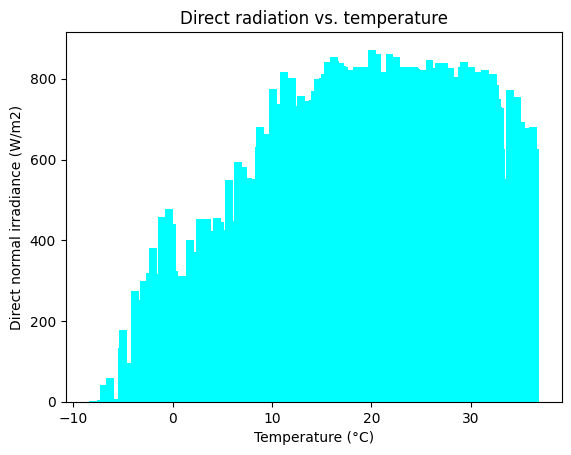

In [ ]:
plt.bar(df_total['FR_temperature'], df_total['FR_radiation_direct_horizontal'], color = 'cyan')
plt.title('Direct radiation vs. temperature')
plt.xlabel('Temperature (°C)', **csfont)
plt.ylabel('Direct normal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Diffuse horizontal irradiance (W/m2)')

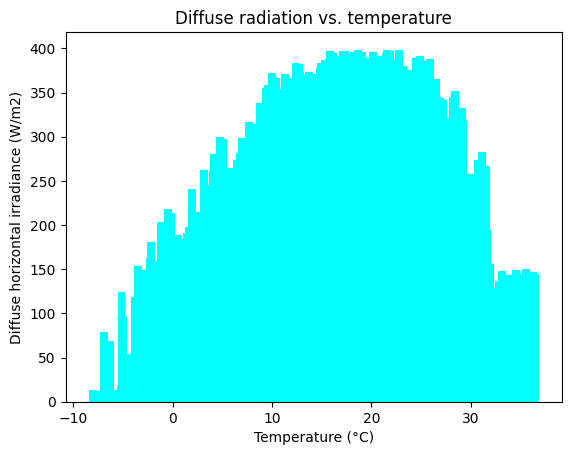

In [ ]:
plt.bar(df_total['FR_temperature'], df_total['FR_radiation_diffuse_horizontal'], color = 'cyan')
plt.title('Diffuse radiation vs. temperature')
plt.xlabel('Temperature (°C)', **csfont)
plt.ylabel('Diffuse horizontal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Global horizontal irradiance (W/m2)')

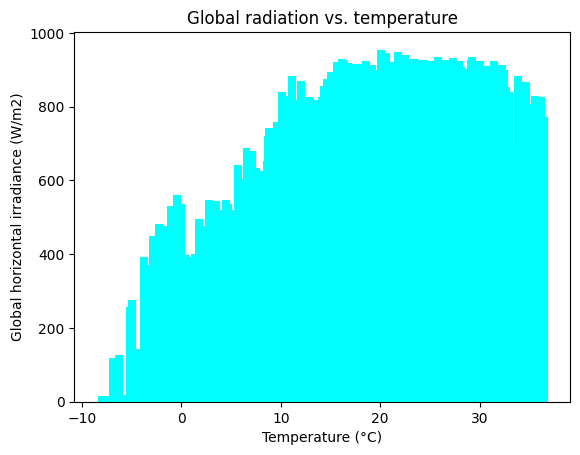

In [ ]:
plt.bar(df_total['FR_temperature'], df_global_radiation, color = 'cyan')
plt.title('Global radiation vs. temperature')
plt.xlabel('Temperature (°C)', **csfont)
plt.ylabel('Global horizontal irradiance (W/m2)', **csfont)

Text(0, 0.5, 'Current load (MW)')

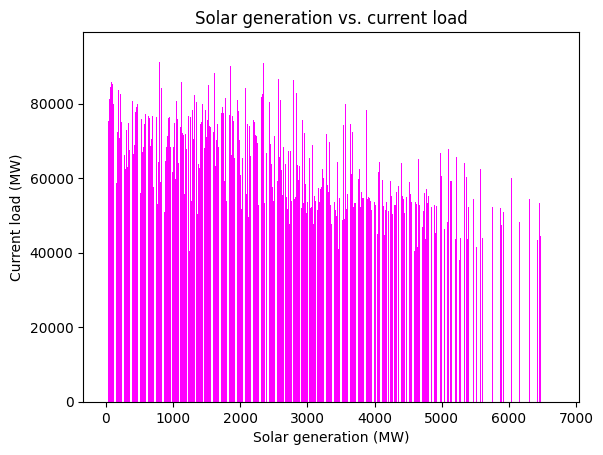

In [ ]:
plt.bar(df_total['FR_solar_generation_actual'], df_total['FR_load_actual_entsoe_transparency'], color = 'magenta')
plt.title('Solar generation vs. current load')
plt.xlabel('Solar generation (MW)', **csfont)
plt.ylabel('Current load (MW)', **csfont)

Text(0, 0.5, 'Forecasted load (MW)')

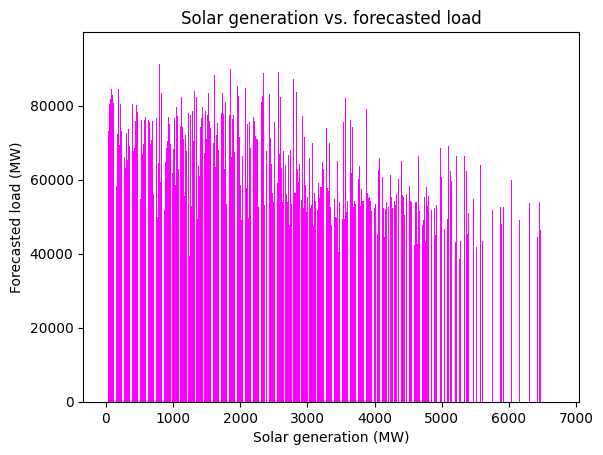

In [10]:
plt.bar(df_total['FR_solar_generation_actual'], df_total['FR_load_forecast_entsoe_transparency'], color = 'magenta')
plt.title('Solar generation vs. forecasted load')
plt.xlabel('Solar generation (MW)', **csfont)
plt.ylabel('Forecasted load (MW)', **csfont)

In [11]:
df_load_combined = df_total['FR_load_forecast_entsoe_transparency'] + df_total['FR_load_actual_entsoe_transparency']

Text(0, 0.5, 'Combined load (MW)')

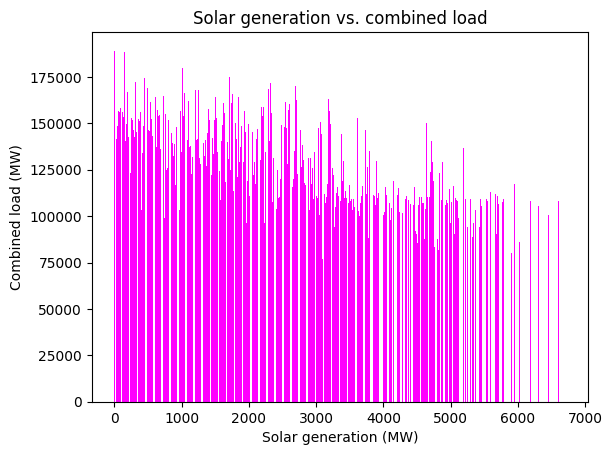

In [12]:
plt.bar(df_total['FR_solar_generation_actual'], df_load_combined, color = 'magenta')
plt.title('Solar generation vs. combined load')
plt.xlabel('Solar generation (MW)', **csfont)
plt.ylabel('Combined load (MW)', **csfont)